# Making Better Clothing Size Recommendations
- Creator: Jacky Dam
- LinkedIn: https://www.linkedin.com/in/jackydam/
- GitHub: https://github.com/jacky3331

## Summary of Findings

### Introduction
As we transition into a world driven by e-commerce, retail business such as the clothing industry face signifcant issues with customers returning products for a variety of issues which especially includes wrong product sizes. This python notebook works to mitigate the issue of customers returning products due to improper fit by leveraging lots of customer data in order to make better clothing size recommendations through machine learning.

In this project, I worked with a clothing dataset from RentTheRunway extracted by the following research team cited below:

#### Decomposing fit semantics for product size recommendation in metric spaces
&emsp; Rishabh Misra, Mengting Wan, Julian McAuley 
 <br>
&emsp; RecSys, 2018

From this dataset which contained about 192,544 raw customer information, I was able to process and extract features which would be later used to create models in order to make size recommendations.

### Cleaning and EDA
Since I was working with a raw dataset extracted by another research team, it was necessary to create a method in order to process the data. This process included standardizing columns such as: weight, height, bust size, age and converting the column datatypes to what made the most sense. Finally, the cleaning process included removing entries which had missing features in which I was left with 146,142 entries which was sufficient in creating a model. One thing to keep in mind is that the clothing category is greatly skewed towards dresses and gowns due to the nature of the clothing website RentTheRunway, but serves as a good proof of concept to market to other clothing companies.

The Exploratory Data Analysis included looking into the basic statistics of the dataset, analyzing the review_text column through a word cloud, and looking into the numerical correlation of features with the product size. Through this analysis, I was able to evaluate the best course of action in order to create an optimal model, and better understand the dataset.

### Model Selection
In my baseline model, I utilized numerical features which included: weight, height, age, and bust size. Additionally, I included categorical features which required one-hot-encoding such as: bust cup, body type, and category. I experimented with various regression algorithms such as Linear Regression, and Decision Tree Regressor in which I recieved the best performance with Decision Tree Regressor of max_depth 10 with a training RSME of 3.70, and test RMSE of 3.88. The test size that I utilized in both the baseline model and final model is 0.2 which means 80% of the data is utilized for the training set, 20% of the data is utilized in the test set.

I chose to use the RMSE as the metric in order to evaluate the model performance because it calculates the total error across the sizes of the collective datapoints. I chose to use RMSE over MSE because it doesn't put more weight on penalizing larger errors which I deemed was not very significant due to the likelyhood that the product would be returned. Across varying categories (some had very little samples sizes), there was a difference in RSME which affected the model performance overall. The RSME tells us the variability of the size differences between the datapoints, and the significance of this number depends on the size spread of that specific category. Ideally, the RMSE is low, but in many clothing category, the size variability might not make a significant difference in customer satisfaction. In several categories, the model made very good size recommendations close to the sizes that the customer would've ordered and served as a great proof of concept for pursuing another final model.

In my final model, I conducted a grid search with varying hyperparameters and ended up choosing the Random Forest Regressor of max_depth: 18, n_estimators: 15, and max_features: auto. The final model performance was better than the baseline and had a train RSME of 2.77, and test RSME of 3.67. Although the final model performance only slightly better than the baseline model, upon further investigation, it seems that the model has trouble recommending sizes for clothing categories which lack sufficient sample sizes. 

### Results & Outcome
In conclusion, this technical analysis indicates that it's possible to create a model which could decently recommend clothing sizes for customers. The significance of this finding is that we're able to mitigate the amount of clothing returns and reduce carbon emission due to shipping & packaging while minimizing profit loss. 

Although this project can decently recommend clothing sizes, it could be further improved by looking into adding more sample sizes for specific categories, exploring different recommender systems based on similar users (jaccard similarity, cosine similarity), adding features such as: gender, more specific body measurements, or utilizing neural networks.

Finally, the next possible steps for utilizing this clothing size recommender tool is to market this technology to other clothing companies, creating an simple User Interface, implement the model as a python application, and making improvements to the data pipeline to improve sample sizes across all clothing categories. Although this model can be deployed immediately, I would recommend making several improvements to the model performance, and implementing this feature to a small subset of customers to gain insights. Additionally, this dataset allows for further project exploration such as sentiment analysis, product recommendations, and web development.

# Code


### Library Imports

In [1]:
import pandas as pd
import numpy as np
import gzip

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

### Data Extraction

In [2]:
def readJSON(path):
    null = None
    
    for l in gzip.open(path, 'rt'):
        yield eval(l)
        
data = list(readJSON("renttherunway_final_data.json.gz"))
data = pd.DataFrame(data)

In [3]:
data.head()

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date
0,fit,420272,34d,2260466,137lbs,10,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,"5' 8""",14,28,"April 20, 2016"
1,fit,273551,34b,153475,132lbs,10,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,"5' 6""",12,36,"June 18, 2013"
2,fit,360448,NaN,1063761,NaN,10,party,This hugged in all the right places! It was a ...,NaN,It was a great time to celebrate the (almost) ...,sheath,"5' 4""",4,116,"December 14, 2015"
3,fit,909926,34c,126335,135lbs,8,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,"5' 5""",8,34,"February 12, 2014"
4,fit,151944,34b,616682,145lbs,10,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,"5' 9""",12,27,"September 26, 2016"


###  Cleaning and EDA

In [4]:
def standardize_height(str_in):
    output = ""
    if "\'" in str_in:
        str_in = str_in.replace('"', "")
        str_in = str_in.split("\' ")
        str_in = int(str_in[0])*12 + int(str_in[1])
        
        output = str_in
    
    return output

def standardize_bust(str_in):
    return str_in[:2]

def standardize_cup(str_in):
    return str_in[2:]

def standardize_age(x):
    if x > 100 or x < 18 or x == "nan":
        return np.NaN
    else:
        return x
    
def clean_data(df):
    # Remove missing entries
    df = df.dropna()
    
    # Standardize numerical features
    df["bust cup"] = df["bust size"].apply(standardize_cup)
    df["bust size"] = df["bust size"].apply(standardize_bust)
    
    df["weight"] = df["weight"].str.replace("lbs", "").astype(float)
    
    df["height"] = df["height"].astype(str)
    df["height"] = df["height"].apply(standardize_height).replace("", np.NaN).astype(float)

    # Specify datatype for columns
    df["fit"] = df["fit"].astype(str)
    df["user_id"] = df["user_id"].astype(str)
    df["bust size"] = df["bust size"].astype(int)
    df["item_id"] = df["item_id"].astype(int)
    df["weight"] = df["weight"].astype(float)
    df["rating"] = df["rating"].astype(int)
    df["rented for"] = df["rented for"].astype(str)
    df["review_text"] = df["review_text"].astype(str)
    df["body type"] = df["body type"].astype(str)
    df["review_summary"] = df["review_summary"].astype(str)
    df["category"] = df["category"].astype(str)
    df["height"] = df["height"].astype(float)
    df["size"] = df["size"].astype(float)
    df["age"] = df["age"].astype(int)
    
    # Standardize Age
    df["age"] = df["age"].apply(standardize_age)
    
    # Remove missing entries
    df = df.dropna()

    return df

In [5]:
data.head()

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date
0,fit,420272,34d,2260466,137lbs,10,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,"5' 8""",14,28,"April 20, 2016"
1,fit,273551,34b,153475,132lbs,10,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,"5' 6""",12,36,"June 18, 2013"
2,fit,360448,NaN,1063761,NaN,10,party,This hugged in all the right places! It was a ...,NaN,It was a great time to celebrate the (almost) ...,sheath,"5' 4""",4,116,"December 14, 2015"
3,fit,909926,34c,126335,135lbs,8,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,"5' 5""",8,34,"February 12, 2014"
4,fit,151944,34b,616682,145lbs,10,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,"5' 9""",12,27,"September 26, 2016"


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192544 entries, 0 to 192543
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   fit             192544 non-null  object
 1   user_id         192544 non-null  object
 2   bust size       174133 non-null  object
 3   item_id         192544 non-null  object
 4   weight          162562 non-null  object
 5   rating          192462 non-null  object
 6   rented for      192534 non-null  object
 7   review_text     192544 non-null  object
 8   body type       177907 non-null  object
 9   review_summary  192544 non-null  object
 10  category        192544 non-null  object
 11  height          191867 non-null  object
 12  size            192544 non-null  int64 
 13  age             191584 non-null  object
 14  review_date     192544 non-null  object
dtypes: int64(1), object(14)
memory usage: 22.0+ MB


In [7]:
data.describe()

,size
count,192544.000000
mean,12.245175
std,8.494877
min,0.000000
25%,8.000000
50%,12.000000
75%,16.000000
max,58.000000


In [8]:
clothing = clean_data(data)
clothing.head()

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date,bust cup
0,fit,420272,34,2260466,137.0,10,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,68.0,14.0,28.0,"April 20, 2016",d
1,fit,273551,34,153475,132.0,10,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,66.0,12.0,36.0,"June 18, 2013",b
3,fit,909926,34,126335,135.0,8,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,65.0,8.0,34.0,"February 12, 2014",c
4,fit,151944,34,616682,145.0,10,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,69.0,12.0,27.0,"September 26, 2016",b
5,fit,734848,32,364092,138.0,8,date,Didn't actually wear it. It fit perfectly. The...,athletic,Traditional with a touch a sass,dress,68.0,8.0,45.0,"April 30, 2016",b


In [9]:
clothing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146142 entries, 0 to 192543
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   fit             146142 non-null  object 
 1   user_id         146142 non-null  object 
 2   bust size       146142 non-null  int32  
 3   item_id         146142 non-null  int32  
 4   weight          146142 non-null  float64
 5   rating          146142 non-null  int32  
 6   rented for      146142 non-null  object 
 7   review_text     146142 non-null  object 
 8   body type       146142 non-null  object 
 9   review_summary  146142 non-null  object 
 10  category        146142 non-null  object 
 11  height          146142 non-null  float64
 12  size            146142 non-null  float64
 13  age             146142 non-null  float64
 14  review_date     146142 non-null  object 
 15  bust cup        146142 non-null  object 
dtypes: float64(4), int32(3), object(9)
memory usage: 17.3+ M

In [10]:
clothing.describe()

,bust size,item_id,weight,rating,height,size,age
count,146142.000000,1.461420e+05,146142.000000,146142.000000,146142.000000,146142.000000,146142.000000
mean,34.111768,1.052212e+06,137.219725,9.081551,65.263059,11.440975,34.093409
std,1.701768,8.092531e+05,21.540950,1.438089,2.658955,7.826571,7.956848
min,28.000000,1.233730e+05,50.000000,2.000000,54.000000,0.000000,18.000000
25%,32.000000,1.956130e+05,123.000000,8.000000,63.000000,4.000000,29.000000
50%,34.000000,9.618190e+05,135.000000,10.000000,65.000000,9.000000,32.000000
75%,36.000000,1.687082e+06,148.000000,10.000000,67.000000,16.000000,37.000000
max,48.000000,2.966087e+06,300.000000,10.000000,78.000000,58.000000,100.000000


In [11]:
clothing.head()

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date,bust cup
0,fit,420272,34,2260466,137.0,10,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,68.0,14.0,28.0,"April 20, 2016",d
1,fit,273551,34,153475,132.0,10,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,66.0,12.0,36.0,"June 18, 2013",b
3,fit,909926,34,126335,135.0,8,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,65.0,8.0,34.0,"February 12, 2014",c
4,fit,151944,34,616682,145.0,10,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,69.0,12.0,27.0,"September 26, 2016",b
5,fit,734848,32,364092,138.0,8,date,Didn't actually wear it. It fit perfectly. The...,athletic,Traditional with a touch a sass,dress,68.0,8.0,45.0,"April 30, 2016",b


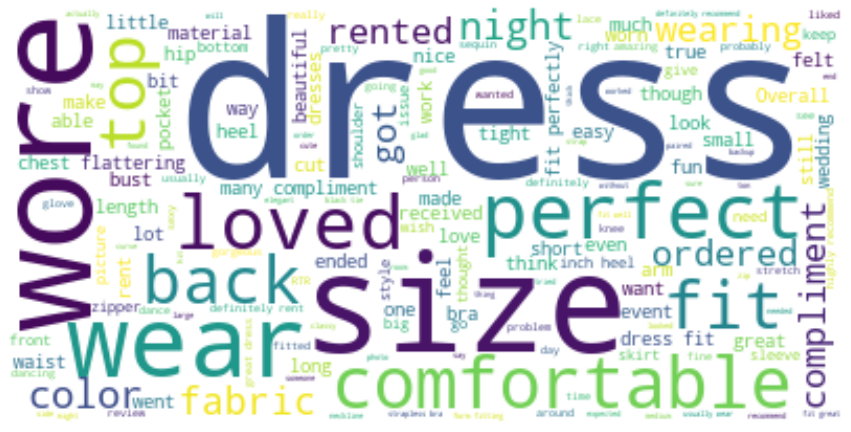

In [12]:
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS

text = " ".join(i for i in clothing["review_text"])
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('WordCloud.png')
plt.show()

<AxesSubplot:>

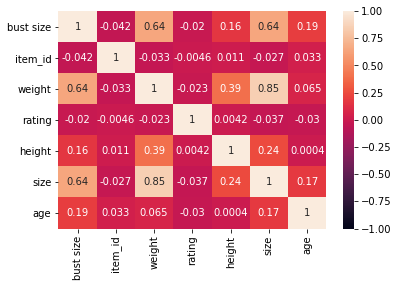

In [13]:
# Observe features from correlation heat map according to the size column.
# We will experiment with bust size, weight, height, and age since they have a positive correlation with size.
sns.heatmap(clothing.corr(), vmin=-1, vmax=1, annot=True)

### Baseline Model

In [14]:
X = clothing[['fit', 'user_id', "bust cup", 'bust size', 'item_id', 'weight', 'rating',
       'rented for', 'review_text', 'body type', 'review_summary', 'category',
       'height', 'age', 'review_date']]
y = clothing['size']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [15]:
performance_df = pd.DataFrame()
nothing_transformer = FunctionTransformer()
preproc = ColumnTransformer(
transformers = [
    ("nothing", nothing_transformer, ["weight", "height", "age", "bust size"]),
    ("onehot", OneHotEncoder(handle_unknown="ignore"), ["bust cup", "category", "body type", "fit"])
])

# Search for the depth which provides the most optimal model performance based on the test set
for depth_ in range(1, 15):
    pl = Pipeline([
        ('preprocessor', preproc),
        ('DecisionTreeClassifer', DecisionTreeRegressor(max_depth=depth_))
         ])

    pl.fit(X_train, y_train)
    
    train_rsme = mean_squared_error(pl.predict(X_train), y_train, squared=False)
    test_rsme = mean_squared_error(pl.predict(X_test), y_test, squared=False)

    output = {"Depth": depth_, "Train rsme": train_rsme, "Test rsme": test_rsme}
    
    performance_df = performance_df.append(output, ignore_index=True)
    
performance_df.iloc[performance_df["Test rsme"].idxmin()]

Depth         10.000000
Train rsme     3.646213
Test rsme      3.841723
Name: 9, dtype: float64

# Final Model

In [16]:
preproc = ColumnTransformer(
transformers = [
    ("nothing", nothing_transformer, ["weight", "height", "age", "bust size"]),
    ("onehot", OneHotEncoder(handle_unknown="ignore"), ["bust cup", "category", "body type", "fit"])
])
pl = Pipeline([
        ('preprocessor', preproc),
        ('clf',  RandomForestRegressor())
         ])


In [17]:
hyperparameters = {
    'clf__max_depth': [12, 15, 18, 21, 24],
    'clf__n_estimators': [12, 15, 18],
    'clf__max_features': ['auto']
}

grids = GridSearchCV(pl, param_grid=hyperparameters, return_train_score=True, scoring="neg_root_mean_squared_error")
grids.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('nothing',
                                                                         FunctionTransformer(),
                                                                         ['weight',
                                                                          'height',
                                                                          'age',
                                                                          'bust '
                                                                          'size']),
                                                                        ('onehot',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['bust '
                                                                          'cup',
                                                                          'category',
                                                                          'body '
                                                                          'type',
                                                                          'fit'])])),
                                       ('clf', RandomForestRegressor())]),
             param_grid={'clf__max_depth': [12, 15, 18, 21, 24],
                         'clf__max_features': ['auto'],
                         'clf__n_estimators': [12, 15, 18]},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [18]:
grids.score(X_train, y_train)

-3.0064749220027487

In [19]:
grids.score(X_test, y_test)

-3.6289683965315134

In [20]:
grids.best_params_

{'clf__max_depth': 15, 'clf__max_features': 'auto', 'clf__n_estimators': 18}

In [21]:
cat = X_test["category"].unique()
output = pd.DataFrame(columns=["category", "Train RSME", "Test RSME"])

for i in cat:    
    y_train_pred = grids.predict(X_train[X_train["category"] == i])
    y_train_temp = y_train[X_train["category"] == i]
    
    y_test_pred = grids.predict(X_test[X_test["category"] == i])
    y_test_temp = y_test[X_test["category"] == i]
    
    temp_dict = {"category": i, "Train RSME": mean_squared_error(y_train_pred, y_train_temp, squared=False), "Test RSME": mean_squared_error(y_test_pred, y_test_temp, squared=False)}
    
    output = output.append(temp_dict, ignore_index=True)

    
output = output.merge(pd.DataFrame(clothing.groupby("category")["size"].min()).rename(columns={"size": "Min Size"}).reset_index(), how="inner", on="category")
output = output.merge(pd.DataFrame(clothing.groupby("category")["size"].max()).rename(columns={"size": "Max Size"}).reset_index(), how="inner", on="category")
output = output.merge(pd.DataFrame(clothing.groupby("category")["size"].count()).rename(columns={"size": "Count"}).reset_index(), how="inner", on="category")

output = output[["category", "Count", "Min Size", "Max Size", "Train RSME", "Test RSME"]].rename(columns={"category": "Category", "Train RSME": "Train RMSE", "Test RSME": "Test RMSE"})
output

,Category,Count,Min Size,Max Size,Train RSME,Test RSME
0,gown,33212,0.0,58.0,3.080774,3.801125
1,dress,70358,0.0,57.0,3.082926,3.573631
2,sheath,14669,1.0,57.0,2.967899,3.897418
3,mini,1414,1.0,24.0,2.546394,2.882818
4,cardigan,195,4.0,20.0,2.712809,4.19549
5,jumpsuit,4012,0.0,51.0,2.840596,3.388536
6,blazer,620,1.0,28.0,2.532217,2.709128
7,coat,769,1.0,35.0,2.705759,3.399124
8,shift,4036,1.0,57.0,2.951176,4.009476
9,top,3777,1.0,28.0,2.635176,3.196914


In [22]:
import dataframe_image as dfi
dfi.export(output, 'dataframe.png')